# Análisis Exploratorio de Datos
## Parte 2 | Análisis técnico

Tanto las finanzas como la economía son dos materias atravesadas de lleno por el comportamiento de las masas, del conjunto de los individuos que conforman una población. Los factores para la toma de decisiones no son estríctamente matemáticos y exactos, sino que están ligados inevitablemente a sentimientos humanos, como el miedo, la emoción y las expectativas. 

Esta forma de ver a dichas materias le da lugar al análisis financiero técnico, una serie de métodos llevados a cabo que buscan predecir el comportamiento de los precios de los activos financieros, como las criptomonedas. La idea principal es, justamente, que los patrones se repiten, ya que parten de los comportamientos de las masas, y estos, a su vez, nacen de los sentimientos previamente mencionados.

Existen muchas métricas para determinar cuando actuar de qué manera. En este caso, nos vamos a centrar en 3: las médias móviles, el RSI, y el volumen. A partir de ellas, y usándolas en conjunto, se pueden ver indicios de una tendencia alcista o bajista, lo que pueden ser señales de compra o venta si son bien interpretadas.

In [321]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import json
import datetime
import os
import ta
import time

In [319]:
# Una copia del array de las 10 criptomonedas elegidas

final_ids = ['ethereum',
 'tron',
 'the-open-network',
 'leo-token',
 'okb',
 'internet-computer',
 'maker',
 'optimism',
 'the-graph',
 'kaspa']

In [315]:
class crypto():
    def __init__(self,id_):
        self.data = json.loads(requests.get(f'https://api.coingecko.com/api/v3/coins/{id_}/ohlc?vs_currency=usd&days=max').content)
        self.id = id_
        self.name = self.normalize_string(id_)
        self.dataframe = self.create_df()

    def create_df(self):
        dataframe = pd.DataFrame(self.data, columns=['date','open', 'high', 'low', 'close'])

        dataframe['name'] = self.name

        desde = dataframe['date'].values[0]
        hasta = dataframe['date'].values[-1]

        desde_unix = desde / 1000
        hasta_unix = hasta / 1000

        market_chart_url = f'https://api.coingecko.com/api/v3/coins/{self.id}/market_chart/range?vs_currency=usd&from={desde_unix}&to={hasta_unix}'

        market_chart_data = json.loads(requests.get(market_chart_url).content)
            
        df_prices = pd.DataFrame(market_chart_data['prices'], columns=['date_prices', 'price'])
        df_market_caps = pd.DataFrame(market_chart_data['market_caps'], columns=['date_market_caps', 'market_cap'])
        df_total_volumes = pd.DataFrame(market_chart_data['total_volumes'], columns=['date_total_volumes', 'total_volume'])

        dataframe = pd.concat([dataframe, df_prices, df_market_caps, df_total_volumes], axis=1, join='inner')

        dataframe.drop(columns=["date_prices", "date_market_caps", "date_total_volumes"], inplace=True)

        
        dataframe = dataframe[['name'] + [col for col in dataframe.columns if col != 'name']]  # Reorganiza las columnas
        dataframe = dataframe.dropna()

        return dataframe
    
    def sma_graph(self, sma_1 = False, sma_2 = False):
        dates = self.dataframe['date'] / 1000 ## Pasando a timestamp
        dates = [datetime.datetime.fromtimestamp(date).strftime('%m/%d/%Y') for date in dates]

        plt.figure(figsize=(14,9))
        plt.plot(dates, self.dataframe['close'], label='Close price')

        if sma_1:
            sma_1_graph = self.dataframe['close'].rolling(sma_1).mean()
            plt.plot(dates, sma_1_graph, label=f'SMA {sma_1} periods')

        if sma_2:
            sma_2_graph = self.dataframe['close'].rolling(sma_2).mean()
            plt.plot(dates, sma_2_graph, label=f'SMA {sma_2} periods')

        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(18))
        plt.gca().yaxis.set_major_locator(plt.MaxNLocator(12))


        plt.xticks(rotation=45, ha='right')
        plt.grid(True, linestyle='--', alpha=0.7)

        plt.title(f'{self.name} price overtime')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')

        plt.legend()
        plt.show()

    def rsi_graph(self):
        dates = self.dataframe['date'] / 1000 ## Pasando a timestamp
        dates = [datetime.datetime.fromtimestamp(date).strftime('%m/%d/%Y') for date in dates]

        rsi = ta.momentum.RSIIndicator(close=self.dataframe['close'], window=14).rsi()


        plt.figure(figsize=(14,4))
        plt.plot(dates, rsi, label='RSI')

        plt.axhline(y=70, color='r', linestyle='--', alpha=0.4, label='Overbought (70)')
        plt.axhline(y=30, color='g', linestyle='--', alpha=0.4, label='Oversold (30)')

        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
        plt.gca().yaxis.set_major_locator(plt.MaxNLocator(10))

        plt.xticks(rotation=45, ha='right')
        plt.grid(True, linestyle='--', alpha=0.7)

        plt.title(f'RSI {self.name}')
        plt.legend()
        plt.show()

    def volume_graph(self):
        dates = self.dataframe['date'] / 1000 ## Pasando a timestamp
        dates = [datetime.datetime.fromtimestamp(date).strftime('%m/%d/%Y') for date in dates]

        plt.figure(figsize=(14,4))

        plt.plot(dates, self.dataframe['total_volume'])

        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
        plt.gca().yaxis.set_major_locator(plt.MaxNLocator(10))

        plt.xticks(rotation=45, ha='right')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        plt.title(f'{self.name} volume')
        plt.xlabel('Date')
        plt.ylabel('Volume')
        plt.show()

    def csv(self):
        folder_path = 'datasets'

        # Crea la carpeta si no existe
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # Guarda el DataFrame en un archivo CSV en la carpeta especificada
        csv_path = os.path.join(folder_path, f'{self.name}.csv')
        csv_dataframe = bitcoin.dataframe.copy()
        csv_dataframe['date'] = csv_dataframe['date'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime('%m/%d/%Y'))
        csv_dataframe.to_csv(csv_path, index=False)

    def normalize_string(self, s):
        capitalized = ' '.join(word.capitalize() for word in s.split('-'))
        return capitalized


In [ ]:
cryptocurrencies = {}

for currency in ids_finales:
    cryptocurrencies[currency] = crypto(currency)

In [326]:
ethereum = crypto('ethereum')

In [327]:
ethereum.dataframe

,name,date,open,high,low,close,price,market_cap,total_volume
0,Ethereum,1438905600000,2.83,2.83,2.830000,2.830,2.831620,0.000000e+00,9.062200e+04
1,Ethereum,1439251200000,1.33,1.33,0.687586,1.067,1.330750,8.033948e+07,3.680700e+05
2,Ethereum,1439596800000,1.26,1.83,1.260000,1.670,0.687586,4.155631e+07,4.004641e+05
3,Ethereum,1439942400000,1.48,1.48,1.200000,1.250,1.067379,6.453901e+07,1.518998e+06
4,Ethereum,1440288000000,1.48,1.48,1.360000,1.360,1.256613,7.601326e+07,2.073893e+06
...,...,...,...,...,...,...,...,...,...
761,Ethereum,1691020800000,1857.28,1869.75,1838.010000,1838.010,329.415663,2.877548e+10,4.313942e+08
762,Ethereum,1691366400000,1835.70,1835.70,1826.710000,1826.710,304.475108,2.832935e+10,6.603927e+08
763,Ethereum,1691712000000,1826.93,1856.84,1826.930000,1850.880,299.694444,2.768128e+10,3.155160e+08
764,Ethereum,1692057600000,1847.54,1848.51,1839.510000,1843.510,292.779657,2.803629e+10,4.568185e+08


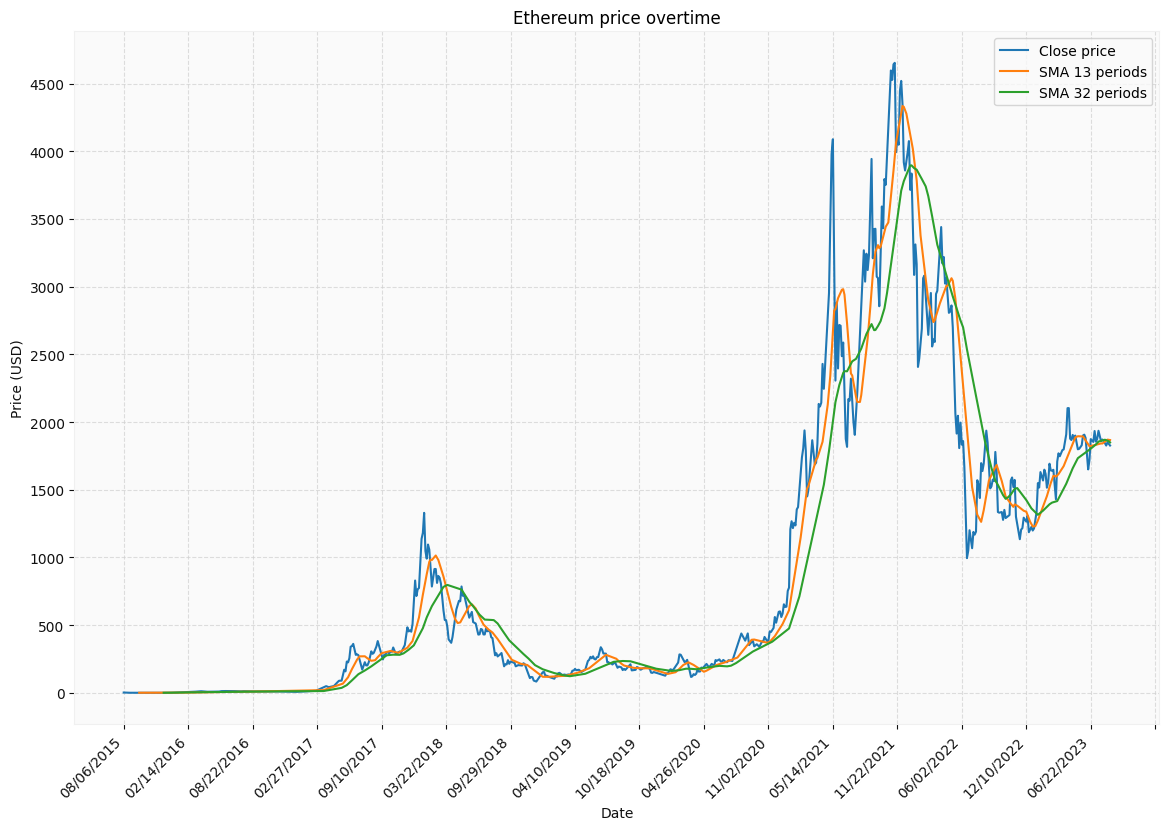

In [328]:
ethereum.sma_graph(13,32)

## Diferencia de medias móviles

En el gráfico superior, se ven 3 líneas: una del precio a lo largo del tiempo, de color azul, una de una media móvil simple de 13 períodos, de color amarilla, y otra media móvil simple, pero esta vez de 32 períodos, de color verde. Una señal alcista es que la media móvil más corta, la amarilla, supere a la alcista. En esos momentos, se recomienda comprar. Por el contrario, cuando es del modo inverso, se recomienda vender. Siguiendo esta fácil regla y apoyándonos en el gráfico, podemos sospechar que, como regla general, funciona, puesto que la mayoría de las veces que se recomendó comprar, se terminó ganando dinero.

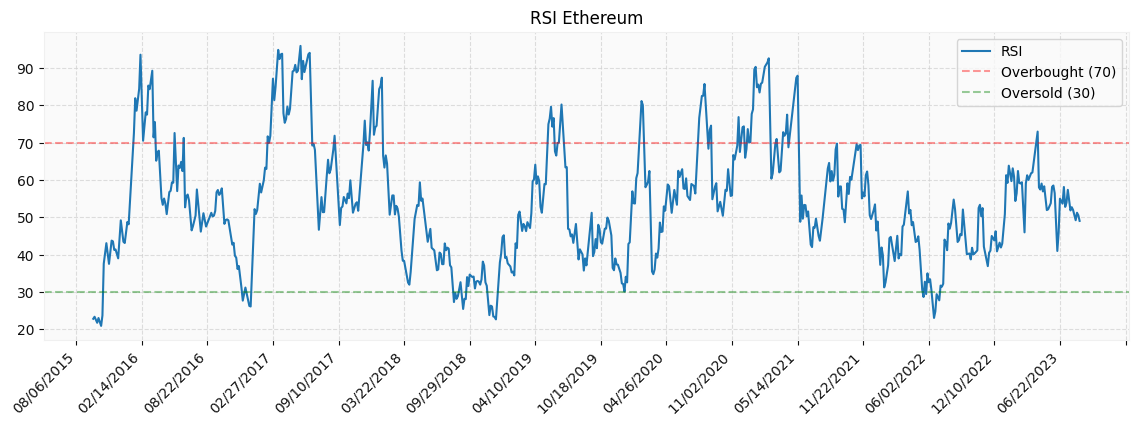

In [329]:
ethereum.rsi_graph()

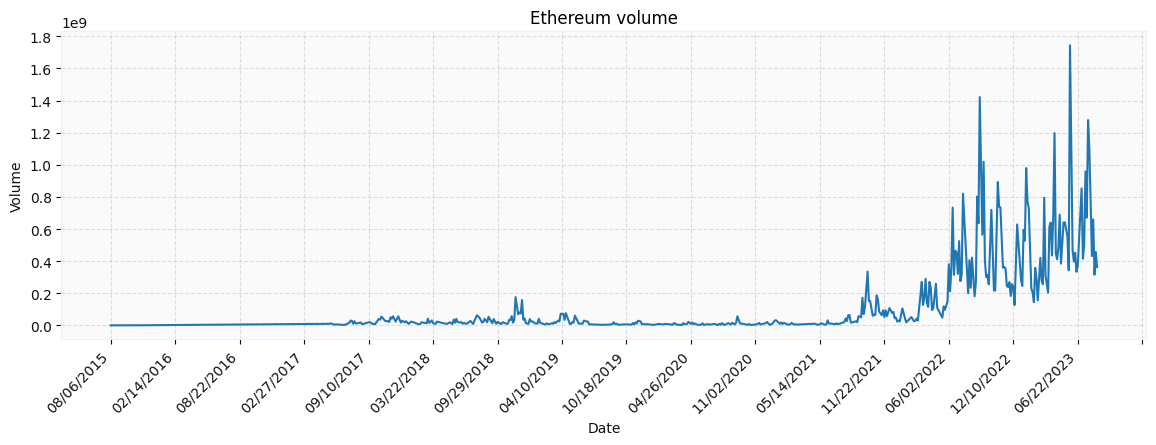

In [330]:
ethereum.volume_graph()

In [324]:
# Creacion de csvs para utilizar en Power BI

total_queries = len(final_ids) * 2
queries_per_minute = 10
waiting_time = 60 / queries_per_minute

for currency in final_ids:
    currency = crypto(currency)
    currency.csv()
    time.sleep(waiting_time)